# Analyzing NYC High School Data 
In this notebook we will clean, transform, and analyze multiple datasets containing information on highschools in New York City. The main goals of this project are: 
1. Cleaing and combining the datasets
2. Discovering correlations between the variables from each data set and the school's SAT score
3. Discovering the relationship between features such as geography, race, and sex and SAT score. 

We will analyze multiple datasets in this notebook, here is a brief description: 

1. SAT scores by school - SAT scores for each high school in New York City
2. School attendance - Attendance information for each school in New York City
3. Class size - Information on class size for each school
4. AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
5. Graduation outcomes - The percentage of students who graduated, and other outcome information
6. Demographics - Demographic information for each school
7. School survey - Surveys of parents, teachers, and students at each school

# Survey Data Dictionary 
Many of the variables from each data set are fairly self explanatory, but the variables from the survey dataset are a bit more difficult to understand. 

* dbn: School identification code (district borough number)
* sch_type: School type (Elementary, Middle, High, etc)
* location: School name
* enrollment: Enrollment size
* borough: Borough
* principal: Principal name
* studentsurvey: Only students in grades 6-12 partipate in the student survey. This field indicates whether or not this school serves any students in grades 6-12.
* rr_s: Student Response Rate
* rr_t: Teacher Response Rate
* rr_p: Parent Response Rate
* N_s: Number of student respondents
* N_t: Number of teacher respondents
* N_p: Number of parent respondents
* nr_s: Number of eligible students
* nr_t: Number of eligible teachers
* nr_p: Number of eligible parents
* saf_p_10: Safety and Respect score based on parent responses
* com_p_10: Communication score based on parent responses
* eng_p_10: Engagement score based on parent responses
* aca_p_10: Academic expectations score based on parent responses
* saf_t_10: Safety and Respect score based on teacher responses
* com_t_10: Communication score based on teacher responses
* eng_t_10: Engagement score based on teacher responses
* aca_t_10: Academic expectations score based on teacher responses
* saf_s_10: Safety and Respect score based on student responses
* com_s_10: Communication score based on student responses
* eng_s_10: Engagement score based on student responses
* aca_s_10: Academic expectations score based on student responses
* saf_tot_10: Safety and Respect total score
* com_tot_10: Communication total score
* eng_tot_10: Engagement total score
* aca_tot_10: Academic Expectations total score

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("Data/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("Data/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("Data/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]


# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
#excel grade stored as date type
class_size = class_size[class_size["GRADE "] == "12-Sep"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [6]:
data['class_size']

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.000000,4.000000,22.564286,18.500000,26.571429,NaN
1,01M332,1,46.000000,2.000000,22.000000,21.000000,23.500000,NaN
2,01M378,1,33.000000,1.000000,33.000000,33.000000,33.000000,NaN
3,01M448,1,105.687500,4.750000,22.231250,18.250000,27.062500,NaN
4,01M450,1,57.600000,2.733333,21.200000,19.400000,22.866667,NaN
...,...,...,...,...,...,...,...,...
578,32K549,32,71.066667,3.266667,22.760000,19.866667,25.866667,NaN
579,32K552,32,102.375000,4.312500,23.900000,19.937500,28.000000,NaN
580,32K554,32,66.937500,3.812500,17.793750,14.750000,21.625000,NaN
581,32K556,32,132.333333,5.400000,25.060000,18.333333,30.000000,NaN


# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.shape

(363, 165)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
#remove unnecessary columns
# Remove columns that are not useful for correlation.
survey_correlations = correlations[["saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",]]

# Change column names
survey_correlations = survey_correlations.rename(index={
    "saf_p_11":"Parents - safety & respect", 
    "com_p_11":"Parents - communication", 
    "eng_p_11":"Parents - engagement", 
    "aca_p_11":"Parents - academic expectations",
    "saf_t_11":"Teachers - safety & respect", 
    "com_t_11":"Teachers - communication", 
    "eng_t_11":"Teachers - engagement", 
    "aca_t_11":"Teachers - academic expectations", 
    "saf_s_11":"Students - safety & respect", 
    "com_s_11":"Students - communication", 
    "eng_s_11":"Students - engagement", 
    "aca_s_11":"Students - academic expectations", 
    "saf_tot_11":"Total - safety & respect", 
    "com_tot_11":"Total - communication", 
    "eng_tot_11":"Total - engagement", 
    "aca_tot_11":"Total - academic expectations"})

Text(0.5, 1.0, 'Survey Fields vs SAT Score')

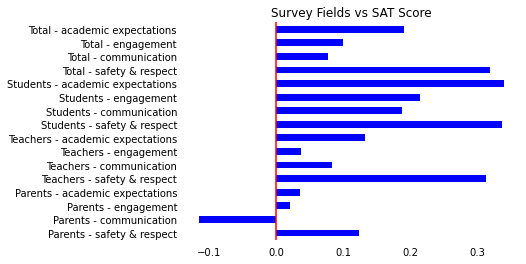

In [13]:
import matplotlib.pyplot as plt 
%matplotlib inline
ax = survey_correlations.plot.barh(color='blue')
ax.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in ax.spines.items():
 spine.set_visible(False)
ax.axvline(c='red')
ax.set_title('Survey Fields vs SAT Score')

It looks like there is a high correlation between SAT score and the amount of academic expecations held by student and teachers, as well as how safety and respect are percieved by these individuals. 

Surprisingly, all fields in the parent surveys have very little correlation with SAT score, and even an inverse correlation when it comes to how parents percieve communicaiton. 

Since we are observing a high correlation between safety scores and SAT scores, lets investigate this relationship further. 

Text(0.5, 1.0, 'saf_s_11 vs sat_score')

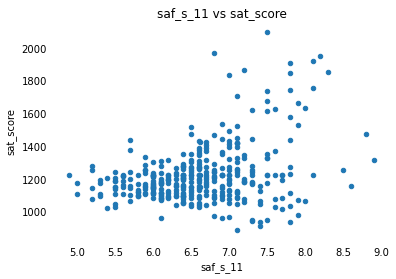

In [14]:
#plot student safety vs sat score 
%matplotlib inline
ax = combined.plot.scatter('saf_s_11', 'sat_score')
ax.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in ax.spines.items():
 spine.set_visible(False)
ax.set_title('saf_s_11 vs sat_score')

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

Text(0.5, 1.0, 'saf_t_11 vs sat_score')

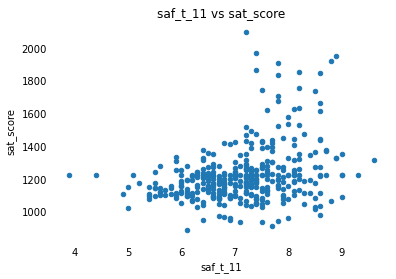

In [15]:
#plot teacher safety vs sat score 
ax = combined.plot.scatter('saf_t_11', 'sat_score')
ax.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in ax.spines.items():
 spine.set_visible(False)
ax.set_title('saf_t_11 vs sat_score')

It looks like this relationship is similiar to the one between student's saftey and respect score  an their SAT scores. But teachers percieve safety and respect to be higher (between 6 and 8) at the same level of SAT scores. 

Now that we better understand the nature of this relationship, let's observe this relationship geographically by calculating the average safety score for each borrough. 

# Saftety Scores by Geographic Location 

Text(0.5, 1.0, 'Teacher Safety Score by Borough')

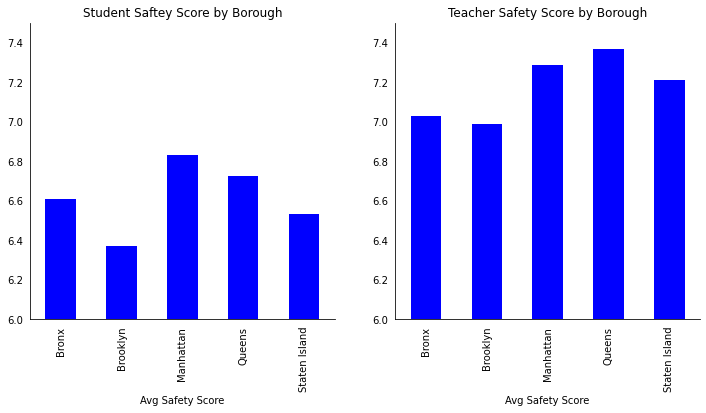

In [16]:
import numpy as np
#average saftey score by geographic area
safety_by_borough = combined.groupby('borough').agg(np.mean)[['saf_p_11', 'saf_s_11', 'saf_t_11', 'saf_tot_11']]
safety_by_borough.reset_index(inplace=True)

#plot between all boroughs
fig = plt.figure(figsize = (12, 12))

#add subplots
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

#students
ax = safety_by_borough.plot.bar(x='borough', y='saf_s_11', ax = ax1, color='blue')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(6, 7.5)
ax.get_legend().remove()
ax.set_xlabel('Avg Safety Score')
ax.set_title('Student Saftey Score by Borough')

#teachers 
ax = safety_by_borough.plot.bar(x='borough', y='saf_t_11', ax=ax2, color='blue')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(6, 7.5)
ax.get_legend().remove()
ax.set_xlabel('Avg Safety Score')
ax.set_title('Teacher Safety Score by Borough')


Brooklyn has the lowest safety score for both students and teachers. Manhaten has the highest safety score for students, while Queens has the highest safety score for teachers. Before moving on, let's take a look at SAT score by borough. 

Text(0.5, 1.0, 'Avg. SAT Score by Borrough')

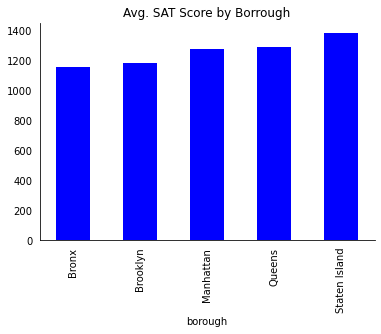

In [17]:
sat_by_borough = combined.groupby('borough').agg(np.mean)['sat_score']

ax=sat_by_borough.plot.bar(x='boro', y='sat_score', color='blue')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Avg. SAT Score by Borrough')

We can see that saftey is not the only factor leading to a higher safety score, with Staten Island, a borrough that recieved lower safety score, has the highest avgerage SAT score. 

Now let's explore the relationship between race and SAT scores. 

# Exploring Race and SAT Scores 

Text(0.5, 1.0, 'Correlations of Race and SAT Score')

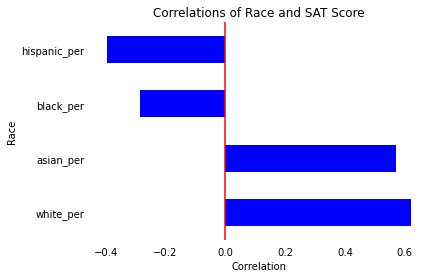

In [18]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_correlations = correlations[race_cols]
#correlations between race and SAT score 
ax = race_correlations.plot.barh(color='blue')
#horizontal line at eor 
ax.axvline(c='r')

ax.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in ax.spines.items():
 spine.set_visible(False)
ax.set_xlabel('Correlation')
ax.set_ylabel('Race')
ax.set_title('Correlations of Race and SAT Score')

Schools with higher percentages of white and asian students are highly correlated with SAT scores. On the other hand, schools with high percentages of black and hispanic students are inversely correlated with SAT scores. There is in fact a gender bias in SAT scores. 

Based on this discovery, let's further explore the relationship between hispanic and black percentages and SAT scores. 

Text(0.5, 1.0, '% White Students vs SAT Score')

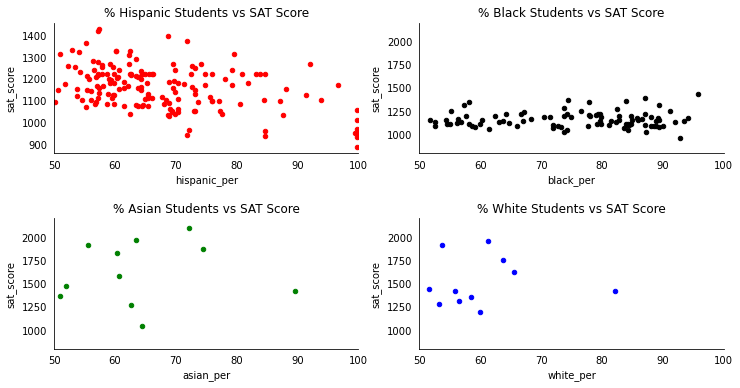

In [19]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0.5)


#set axis 
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

#filter schools by majority 
his_schools = combined[combined['hispanic_per'] > 50]
black_schools = combined[combined['black_per'] > 50]
asian_schools = combined[combined['asian_per'] > 50]
white_schools = combined[combined['white_per'] > 50]

#hispanic
ax = his_schools.plot.scatter('hispanic_per', 'sat_score', ax=ax1, color='red')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(50,100)
ax.set_title('% Hispanic Students vs SAT Score')

#black 
ax = black_schools.plot.scatter('black_per', 'sat_score', ax=ax2, color='black')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(50,100)
ax.set_ylim(800, 2200)
ax.set_title('% Black Students vs SAT Score')

#asian 
ax = asian_schools.plot.scatter('asian_per', 'sat_score', ax=ax3, color='green')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(50,100)
ax.set_ylim(800, 2200)
ax.set_title('% Asian Students vs SAT Score')

#white
ax = white_schools.plot.scatter('white_per', 'sat_score', ax=ax4, color='blue')
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(50,100)
ax.set_ylim(800, 2200)
ax.set_title('% White Students vs SAT Score')

The relationship between race and SAT score mentioned above is further clarified, although the positive linear relationship between Asian and White % is not as strong as the linear relationship between Black and Hispanic %. 

There are also much  more schools with more Hispanic and Black students than schools with more White and Asian students. 

Now let's investigate what kinds of schools have high percentages of Hispanic students to see if there is anything else causing this strong inverse relationship. 

In [20]:
large_hispanic = combined[combined['hispanic_per'] > 95]
large_hispanic['SchoolName']

44             Manhattan Bridges High School
82                                         0
89            GREGORIO LUPERON HS SCI & MATH
125      Academy for Language and Technology
141    International School for Liberal Arts
176                                        0
253                Multicultural High School
286                                        0
Name: SchoolName, dtype: object

After some research, it appears that many of these schools cater to immigrants who are learning English. Let's calculate the average SAT score of these schools. 

In [21]:
large_hispanic['sat_score'].mean()

992.375

It is very understandable that these schools have very low SAT scores on averare. Now let's see what kind of schools have low percetnages of Hispanic students and see if there is a similair relaionship. 

In [22]:
small_hispanic = combined[combined['hispanic_per'] < 10]
small_hispanic[small_hispanic['SchoolName'] != 0]['SchoolName']

37                                         STUYVESANT HS
46       High School for Dual Language and Asian Studies
151                                  BRONX HS OF SCIENCE
187                                BROOKLYN TECHNICAL HS
192                          Bedford Academy High School
194                            BENJAMIN BANNEKER ACADEMY
220                                    BOYS AND GIRLS HS
223    Academy for College Preparation and Career Exp...
226              High School for Global Citizenship, The
229    High School for Youth and Community Developmen...
235                        MIDDLE COLL HS @ MEDGAR EVERS
236                                     CLARA BARTON VHS
280          Brooklyn Collegiate: A College Board School
327                  Queens HS for Science York Colllege
330                           Queens Preparatory Academy
331    Pathways College Preparatory School: A College...
353                                       TOTTENVILLE HS
356                           S

Many of these highschools are extremely technical colleges based arounf Brooklyn and Queens, areas with very low Hispanic populations.

In [23]:
round(small_hispanic['sat_score'].mean(), 2)

1318.41

These schools show well beyond the average SAT score across the country. Now that we see there is a clear racial bias in SAT scores, let's see if there is a gender bias as well. 

# Exploring Gender Bias in SAT Scores 

Text(0.5, 1.0, 'Correlations of Sex and SAT Score')

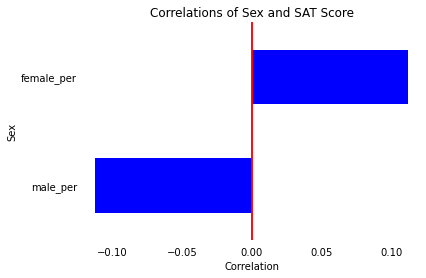

In [24]:
sex_correlations = correlations[['male_per', 'female_per']]
#male_per, female_per
ax = sex_correlations.plot.barh(color='blue')
ax.axvline(c='r')
ax.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in ax.spines.items():
 spine.set_visible(False)
ax.set_xlabel('Correlation')
ax.set_ylabel('Sex')
ax.set_xlim(-.12, .12)
ax.axvline(c='r')
ax.set_title('Correlations of Sex and SAT Score')


There are almost exactly opposite correlations between both sexes and SAT score. The percentage of males in a school has a correlation with sat score of roughly -.12, while the percentage of females in a school has a correlation with sat score of .12. Lets investiaget the relattionship between female_per and sat_score further. 

Text(0.5, 1.0, '% Female vs SAT Score')

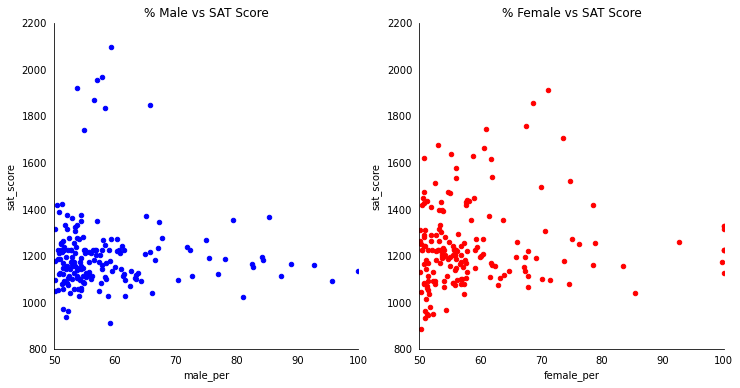

In [25]:
#create figure 
fig = plt.figure(figsize=(12, 6))

#set axis 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#subset data to make charts more cear
high_male = combined[combined['male_per'] > 50]
high_female = combined[combined['female_per'] > 50]

#men vs sat score 
ax = high_male.plot.scatter(x='male_per', y='sat_score', ax=ax1,color='blue')
ax.set_ylim(800,2200)
ax.set_xlim(50,100)
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('% Male vs SAT Score')

#female vs sat_score
ax = high_female.plot.scatter(x='female_per', y='sat_score', ax=ax2,color='red')
ax.set_ylim(800,2200)
ax.set_xlim(50,100)
ax.tick_params(bottom=False, left=False, top=False, right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('% Female vs SAT Score')



Most schools with more females have slightly higher SAT scores than schools with mostly males. There is an interesting gap in schools with mostly male studentt between SAT scores of 1400 and 2000+. There also seems to be much more all girl schools than all boy schools. Let's take a look at schools who have mostly women. 

In [26]:
high_sat_fem = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
high_sat_fem[high_sat_fem['school_name'] != 0]['school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

Most of these schools are college prepatory schools, showing that having a school that is mostly female does not neccesarily lead to high SAT scores. 

Now let's investigate the relationship between the percentage of students that have taken an Advanced Placement (AP) exam and SAT scores. 

Text(0.5, 1.0, '% AP Tests Taken vs SAT Score')

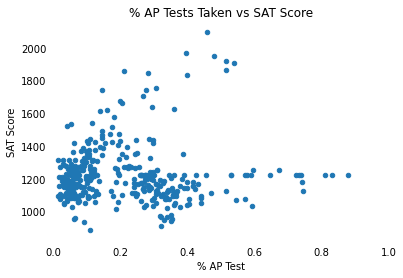

In [27]:
#create new column to calculate # AP exams 
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

ax = combined.plot.scatter(x='ap_per', y='sat_score')
ax.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in ax.spines.items():
 spine.set_visible(False)
ax.set_xlabel('% AP Test')
ax.set_ylabel('SAT Score')
ax.set_xlim(0,1)
ax.set_title('% AP Tests Taken vs SAT Score')

As expected, there is a strong positive relationship between the percentage of students who have taken AP tests and SAT socres, with the majority of htese students scoring in the 1200 range.  

# Conclusion
We found the many factors can contribute to a school's average SAT score (race, gender location, etc.), not just the student's ability. For example, we found that school's with high proportions of Black or Latino students tend to have lower SAT scores than schools with high percentages of white or asian students. 

Gender also plays a role in SAT scores, where school's with a majority of female students having higher SAT scores than schools with a majorty of their students being male. 